## Define the Objective of the Analysis

...

Analisi del sentiment relativo al dibattito sullo _Smart Working_ in Italia e individuazione di eventuali 'influencer' sul tema.

## Collect Data

In [1]:
# imports
import numpy as np
import pandas as pd
import tweepy
tweepy.__version__

import re
import string
import itertools
from collections import Counter
from datetime import datetime
from numpy.core.multiarray import result_type
import time

In [2]:
# insert the keys here
consumer_key = 'VPzjkqKl2y1uSTJQvnVqS9e1X' 
consumer_secret = 'STG2IzVMf65vPGeOvBQyzdeoKBExAr5sIkhOaBeDe2fnIN14vY'
access_token = '1508409949835214853-HIyZJ3oT32TijKsdNDhGFZEEQTWwau'
access_token_secret = 'uLcs9hUYmLdocxkaSfXo69Gii46TISu5qZj5F6f6fBfnW'

#### Tweets Download

The next step is creating an OAuthHandler instance. We pass our consumer key and access token which we defined above.

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

Next, we pass the OAuthHandler instance into the API method.

In [4]:
api = tweepy.API(auth, wait_on_rate_limit=True)

Tweets that contain a specific hashtag

In [35]:
from tqdm.notebook import tqdm
import json
import time
hashtag = '("#smartworking" OR "#remotework" OR "#lavoroagile" OR "#remoteworking" OR "#agileworking" OR "#lavorodacasa")'

list_tweets = []

for tweet in tweepy.Cursor(api.search_tweets, q=hashtag, count=500, lang='it', until='2022-12-30').items(100000):
  # print('entering')
  full_text = api.get_status(tweet.id, tweet_mode='extended')._json['full_text']
  # print(weett.id)
  list_tweets.append([tweet.created_at, tweet.id, full_text, tweet.favorite_count, tweet.retweet_count, tweet.user.screen_name,
                      tweet.user.location, tweet.retweeted, json.dumps(tweet.entities['user_mentions']), json.dumps(tweet.entities['hashtags'])])

# items is the maximum number of tweets to download.
# count is the number of tweets to return per page, up to a maximum of 100.

Tweets that contain a specific keyword

In [5]:
from tqdm.notebook import tqdm
import json
import time
keywords = '("smartworking" OR "remotework" OR "lavoroagile" OR "hybridwork" OR "smart working" OR "remote work" OR "lavoro agile" OR "hybrid work")'

list_tweets = []

for tweet in tweepy.Cursor(api.search_tweets, q=keywords, count=100, lang='it').items(10000):
  full_text = api.get_status(tweet.id, tweet_mode='extended')._json['full_text']
  list_tweets.append([tweet.created_at, tweet.id, full_text, tweet.favorite_count, tweet.retweet_count, tweet.user.screen_name,
                      tweet.user.location, tweet.retweeted, json.dumps(tweet.entities['user_mentions']), tweet.entities['hashtags']])

# items is the maximum number of tweets to download.
# count is the number of tweets to return per page, up to a maximum of 100.

In [7]:
print(len(list_tweets))

900


In [8]:
# Turn list_tweet into a DataFrame changing column names
tweets = pd.DataFrame(list_tweets, columns=['date','id','text','like','n_rt','author','location','retweeted','user_mentions','hastags'])
tweets.to_csv('../data/SW2_ex.csv')

In [14]:
df1 = pd.read_csv('../data/SW.csv')
df3 = pd.read_csv('../data/SW3.csv')
df4 = pd.read_csv('../data/SW4.csv')
df6 = pd.read_csv('../data/SW6.csv')
df7 = pd.read_csv('../data/SW7.csv')
df8 = pd.read_csv('../data/SW8.csv')
df9 = pd.read_csv('../data/SW9.csv')

df10 = pd.read_csv('../data/SW1_ex.csv')
df11 = pd.read_csv('../data/SW2_ex.csv')
tweets = pd.concat([df1, df3, df4, df6, df7, df8, df9, df10, df11])

In [15]:
len(tweets)

4304

In [16]:
# Read csv
tweets = pd.read_csv('../data/SW3.csv')
#tweets_loaded = tweets_loaded.drop('Unnamed: 0', axis=1)
tweets.head()

,Unnamed: 0,date,id,text,like,n_rt,author,location,retweeted,user_mentions,hastags
0,0,2023-01-03 15:45:33+00:00,1610301347206774784,LAVORO DA CASA: COSA PREVEDE LA PROROGA DEL GO...,0,0,laleggepertutti,"Cosenza, Calabria",False,[],[]
1,1,2023-01-03 15:25:08+00:00,1610296208240640001,"RT @bioccolo: #Mattarella ha detto: ""Pensare d...",0,3,rsimoni62,NaN,False,"[{""screen_name"": ""bioccolo"", ""name"": ""bioccolo...","[{""text"": ""Mattarella"", ""indices"": [14, 25]}]"
2,2,2023-01-03 14:50:19+00:00,1610287446356377600,RT @Ernesto23710724: @AntonioNaddeo @ilmessagg...,0,1,Stella_Torraco,NaN,False,"[{""screen_name"": ""Ernesto23710724"", ""name"": ""E...","[{""text"": ""smartworking"", ""indices"": [126, 139]}]"
3,3,2023-01-03 14:50:10+00:00,1610287408477609984,RT @AntonioNaddeo: Intervista sul @ilmessagger...,0,4,Stella_Torraco,NaN,False,"[{""screen_name"": ""AntonioNaddeo"", ""name"": ""Ant...","[{""text"": ""smartworking"", ""indices"": [88, 101]}]"
4,4,2023-01-03 14:15:30+00:00,1610278684719562752,RT @AntonioNaddeo: Intervista sul @ilmessagger...,0,4,lconsolati1,Titolare Studio Consulenza Dir,False,"[{""screen_name"": ""AntonioNaddeo"", ""name"": ""Ant...","[{""text"": ""smartworking"", ""indices"": [88, 101]}]"


In [ ]:
print(tweets.shape)
print(tweets.columns)

#### Data Pre-Processing

In [17]:
# Remove duplicates
tweets.drop_duplicates(subset ="id", inplace = True)
tweets.reset_index(drop = True, inplace = True)
tweets.shape

(644, 11)

In [18]:
# Change date format
day = tweets['date'].dt.day
month = tweets['date'].dt.month
year = tweets['date'].dt.year

date = year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2)
date = pd.to_datetime(date, format='%Y%m%d')
tweets.drop(columns = ['date'], inplace = True)
tweets['date'] = date

# Reorder columns
cols = tweets.columns.tolist()
cols = cols[-1:] + cols[:-1]
tweets = tweets[cols].copy()

print('Tweet per day:')
print()
print(tweets.groupby('date').count()['id'])
print()
print()
print('Maximum Tweet ID per day:')
print()
print(tweets.groupby('date').max('id')['id'])

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# Create a DataFrame with the authors of the tweets and their respective frequency
freq_authors = tweets['author'].value_counts()
freq_authors.head()

In [ ]:
# Extract all hashtags from the full text
tweets['hashtags_list'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

# Extract all mentions from the full text
tweets['mentions'] = tweets['text'].apply(lambda x: re.findall(r"@(\w+)", x))

# \w matches any single letter, number or underscore (same as [a zA Z0 9_])

#### Data Cleaning

NLTK - Natural Language ToolKit is a platform for building Python programs to work with human language data. It provides easy to use interfaces to over 50 corpora and lexical resources, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

In [ ]:
import nltk
from nltk import FreqDist
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

Text Pre-Processing

In [ ]:
def preprocess_data(data):
    # remove numbers and turning words into lower case
    data = data.astype(str).str.replace('\d+','')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = TweetTokenizer()
    
    # token lemmatization (ex. goes --> go)
    def lemmatize_text(text):
        return[(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    
    # remove punctuation
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [ ]:
# apply preprocess_data function
pre_tweets = preprocess_data(tweets['text'])
tweets['text_proc'] = pre_tweets

# delete italian stopwords
stop_words = set(stopwords.words('italian'))
tweets['text_proc'] = tweets['text_proc'].apply(lambda x: [item for item in x if item not in stop_words])

## Analysis

### Social Content Analysis

#### _Sentiment Analysis_

When dealing with social media text, we usually want to identify urls, hashtags, smileys as separate objects and do not tokenize it to individual characters.

VADER - Eng

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
tweets[['text', 'text_proc']]

In [ ]:
tweets['scores'] = tweets['text'].apply(lambda Tweet:sent_analyzer.polarity_scores(Tweet))
tweets['compound'] = tweets['scores'].apply(lambda score_dict:score_dict['compound'])

tweets.head()

FEEL-IT: Emotion and Sentiment Classification for the Italian Language.

https://towardsdatascience.com/sentiment-analysis-and-emotion-recognition-in-italian-using-bert-92f5c8fe8a2

In [ ]:
from feel_it import EmotionClassifier, SentimentClassifier

sentiment_classifier = SentimentClassifier()
emotion_classifier = EmotionClassifier()

The feel-it-italian-sentiment model performs sentiment analysis on Italian. We fine-tuned the UmBERTo model on our new dataset (i.e., FEEL-IT) obtaining state-of-the-art performances on different benchmark corpora.

In [ ]:
print(sentiment_classifier.predict(tweets["text"].values.tolist()))

In [ ]:
tweets_sentiment = tweets.copy()

In [ ]:
text = tweets_sentiment['text']
li_sent = []
for i in range(0, text.shape[0]):
  sent = sentiment_classifier.predict([text[i]])
  li_sent.append(sent)
  if i % 5000 == 0:
    print('Riga',i,'su',text.shape[0])

tweets_sentiment['sentiment_BERT'] = [item for sublist in li_sent for item in sublist]
     
positive = []
negative = []

In [ ]:
positive = []
negative = []
ratio = []

for line in tweets_sentiment.values:
  sent = line[15]

  if sent == 'negative':
    positive.append(0)
    negative.append(1)
    ratio.append(-1)
  else:
    positive.append(1)
    negative.append(0)
    ratio.append(1)

In [ ]:
tweets_sentiment['positive'] = positive
tweets_sentiment['negative'] = negative
tweets_sentiment['ratio'] = ratio

In [ ]:
tweets_sentiment.head()

In [ ]:
tweets_sentiment.to_csv('../data/SW_sentiment.csv')

#### _Emotion Analysis_

Recognizing emotions in text is fundamental to get a better sense of how people are talking about something. People can talk about a new event, but positive/negative labels might not be enough.

The feel-it-italian-emotion model performs emotion classification (joy, fear, anger, sadness) on Italian. We fine-tuned the UmBERTo model on our new dataset (i.e., FEEL-IT) obtaining state-of-the-art performances on different benchmark corpora.

In [ ]:
print(emotion_classifier.predict(tweets["text"].values.tolist()))

In [ ]:
tweets_emotion = tweets.copy()

In [ ]:
text = tweets_emotion['text']
li_emotion = []
for i in range(0, text.shape[0]):
  emotion = emotion_classifier.predict([text[i]])
  li_emotion.append(emotion)
  if i % 5000 == 0:
    print('Riga',i,'su',text.shape[0])

tweets_emotion['emotion_BERT'] = [item for sublist in li_emotion for item in sublist]
     
anger = []
joy = []
fear = []
sadness = []

In [ ]:
anger = []
joy = []
fear = []
sadness = []

for line in tweets_emotion.values:
  emotion = line[15]

  if emotion == 'anger':
    anger.append(1)
    joy.append(0)
    fear.append(0)
    sadness.append(0)
  elif emotion == 'joy':
    anger.append(0)
    joy.append(1)
    fear.append(0)
    sadness.append(0)
  elif emotion == 'fear':
    anger.append(0)
    joy.append(0)
    fear.append(1)
    sadness.append(0)
  else:
    anger.append(0)
    joy.append(0)
    fear.append(0)
    sadness.append(1)

In [ ]:
tweets_emotion['anger'] = anger
tweets_emotion['joy'] = joy
tweets_emotion['fear'] = fear
tweets_emotion['sadness'] = sadness

In [ ]:
tweets_emotion.head()

In [ ]:
tweets_emotion.to_csv('../data/SW_emotion.csv')

---

#### Social Network Analysis

In [2]:
import pandas as pd


In [5]:
first = pd.read_csv('../data/SW.csv')
second = pd.read_csv('../data/SW2.csv')

dataset = pd.concat([first,second], axis=0, ignore_index=True)

In [6]:
dataset.head()

,Unnamed: 0,date,id,text,like,n_rt,author,location,retweeted,user_mentions,hastags
0,0,2022-12-31 14:43:44+00:00,1609198624671469570,RT @aleale2780: @carettamc11 @FratellidItalia ...,0,11,alessiobar4,NaN,False,"[{'screen_name': 'aleale2780', 'name': 'Aleale...","[{'text': 'opzionedonna', 'indices': [113, 126]}]"
1,1,2022-12-31 14:24:56+00:00,1609193893228150787,RT @aleale2780: @carettamc11 @FratellidItalia ...,0,11,martin_marzia,NaN,False,"[{'screen_name': 'aleale2780', 'name': 'Aleale...","[{'text': 'opzionedonna', 'indices': [113, 126]}]"
2,2,2022-12-31 14:20:40+00:00,1609192822271270914,RT @marcoz984: Ripetete con me: lo #smartworki...,0,7,Ernesto23710724,NaN,False,"[{'screen_name': 'marcoz984', 'name': ""marco d...","[{'text': 'smartworking', 'indices': [35, 48]}]"
3,3,2022-12-31 14:04:22+00:00,1609188720170647559,RT @IlConteIT: Per contrastare una nuova possi...,0,4,antomariateres1,NaN,False,"[{'screen_name': 'IlConteIT', 'name': 'ConCont...","[{'text': 'Covid', 'indices': [63, 69]}, {'tex..."
4,4,2022-12-31 13:54:03+00:00,1609186120457240581,RT @dukana2: Toglietevi subito quelle mascheri...,0,11,dukana2,NaN,False,"[{'screen_name': 'dukana2', 'name': 'dukana', ...","[{'text': 'Smartworking', 'indices': [72, 85]}..."


In [47]:
author_mentions = tweets[['author', 'user_mentions']]
author_mentions.head()


,author,user_mentions
0,lconsolati1,"[{""screen_name"": ""AntonioNaddeo"", ""name"": ""Ant..."
1,Ernesto23710724,"[{""screen_name"": ""bioccolo"", ""name"": ""bioccolo..."
2,sposaisterica,"[{""screen_name"": ""bioccolo"", ""name"": ""bioccolo..."
3,bioccolo,[]
4,JTI_Italia,[]


In [48]:
import networkx as nx
import json
import re
import matplotlib.pyplot as plt
Graph = nx.Graph()

for index, row in author_mentions.iterrows():
  print(row[0])
  mentions_array = json.loads(row[1])
  for item in mentions_array:
    Graph.add_edge(row[0], item['screen_name'])
nx.draw(Graph, pos=nx.spring_layout(Graph))


lconsolati1
Ernesto23710724
sposaisterica
bioccolo
JTI_Italia
aran_agenzia
Ernesto23710724
eia58
Ernesto23710724
AntonioNaddeo
Ernesto23710724
aleale2780
Giangi_ilBoomer
FondazioneStudi
LeggiOggi_it
PrimoBonacina
mrmcphisto
TuttoQuaNews
aleale2780
QuoSicurezza
ansia_e_spritz
challengentwrk
danilopremoli
Delilah17tw
ColperTraining
vorrestisparire
mrmcphisto
lentepubblica
StudioPaserioS
Ordine_CDL_NA
Ordine_CDL_NA
TravelTwitt3r
aleale2780
saragra98354743
saragra98354743
saragra98354743
Nonnina10
lucague46760617
ForteMickey
Gugo2013G
mrmcphisto
jobsviatweet
Ricercamy
ma_rosati
TouchYourMoment
AvrioITA
scuradi
GGImageItalia
FinanciaLounge
iotty_italia
Muivida1
Muivida1
gminguzzi
millionaireit
CorriereUniv
laleggepertutti
lucague46760617
lucague46760617
salvatopo
salvatopo
salvatopo
salvatopo
FondazioneStudi
diciommomario
RepubblicaAF
Te_Ti_2020
inCOWORK_ing
prestiter
Rob55045898
VotaSpartaco
margherita_n72
militello_e
6StringsUmarell
mrmcphisto
FrancescoPonzin
CapaGira
bioccolo
mrmcphisto


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 3 (char 2)

In [34]:
nodes_degree_df = pd.DataFrame(nx.degree(Graph))
nodes_degree_df.sort_values(1, ascending=False).head(20)
nodes_degree = [row for index, row in nodes_degree_df.iterrows() if row[1] > 2]


## Nodes with higher degree

In [37]:
nodes_degree_df.sort_values(1, ascending=False).head(20)


,0,1
18,mrmcphisto,81
12,GiorgiaMeloni,68
10,aleale2780,57
5,bioccolo,45
247,Lucapadova25,34
14,ClaudioDurigon,30
4,Ernesto23710724,29
38,lucague46760617,27
15,FratellidItalia,27
174,Corriere,25


## Average degree

In [40]:
degree_data = nodes_degree_df[1].values
average_degree = np.average(degree_data)
print(f'The average degree of the graph is: {average_degree}')


The average degree of the graph is: 3.704761904761905


Siccome il grado medio e' maggiore di 1 molto probabilmente e' sorta una giant component

## Calcolo assortativity

In [43]:
assortativity = networkx.degree_pearson_correlation_coefficient(Graph)
print(f'The assortativity coefficient is: {assortativity}')


The assortativity coefficient is: -0.23489476053911387


Stranamente, nonostante la rete presa in esame sia una rete sociale, il coefficiente di assortativity e' minore di 0, anche se di poco, quindi la rete e' di tipo disassortitive

In [32]:
len(nodes_degree)
nodes_degree[0]

0    lconsolati1
1              3
Name: 0, dtype: object

Measures of Centrality

Community Detection

In [10]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Plasma256
from bokeh.transform import linear_cmap
import networkx
from networkx.algorithms import community as networkxCommunity


In [11]:
from bokeh.io import output_notebook, show, save


In [56]:
output_notebook()


Loading BokehJS ...

In [12]:
communities = networkxCommunity.greedy_modularity_communities(Graph)



In [13]:
modularity_class = {}
modularity_color = {}

for community_number, community in enumerate(communities):
    for name in community:
        
        modularity_class[name] = community_number
        modularity_color[name] = Plasma256[community_number]


In [14]:
networkx.set_node_attributes(Graph, modularity_class, 'modularity_class')
networkx.set_node_attributes(Graph, modularity_color, 'modularity_color')
networkx.set_node_attributes(Graph, modularity_class, 'group')


In [30]:
from collections import Counter
Counter(modularity_class).most_common()
comm_list = [modularity_class[x] for x in modularity_class]

count_dict = {}

for item in comm_list:
  if str(item) not in count_dict:
    count_dict[str(item)] = 1
  else:
    count_dict[str(item)] += 1

In [31]:
count_dict


{'0': 79,
 '1': 65,
 '2': 53,
 '3': 29,
 '4': 27,
 '5': 19,
 '6': 12,
 '7': 12,
 '8': 11,
 '9': 11,
 '10': 10,
 '11': 7,
 '12': 6,
 '13': 5,
 '14': 5,
 '15': 4,
 '16': 4,
 '17': 3,
 '18': 3,
 '19': 3,
 '20': 3,
 '21': 3,
 '22': 3,
 '23': 2,
 '24': 2,
 '25': 2,
 '26': 2,
 '27': 2,
 '28': 2,
 '29': 2,
 '30': 2,
 '31': 2,
 '32': 2,
 '33': 2,
 '34': 2,
 '35': 2,
 '36': 2,
 '37': 2,
 '38': 2,
 '39': 2,
 '40': 2,
 '41': 2,
 '42': 2,
 '43': 2,
 '44': 1}

In [29]:
print(len(comm_list))

420


In [24]:
modularity_class

{'rome_sea': 0,
 'Antonio_Tajani': 0,
 'SaraEurid': 0,
 'bioccolo': 0,
 '6StringsUmarell': 0,
 'vaniatoni2': 0,
 'JenaSnake': 0,
 'jymbo79': 0,
 'LaVeritaWeb': 0,
 'SmartWorkersUn1': 0,
 'AmicoDeiCani': 0,
 'ValePieraccini': 0,
 'Ernesto23710724': 0,
 'Stidolf1': 0,
 'herroyalblues': 0,
 'Cor_Com': 0,
 'saragra98354743': 0,
 'Quirinale': 0,
 'Maria_keepcalm': 0,
 'aran_agenzia': 0,
 'Palazzo_Chigi': 0,
 'pfmajorino': 0,
 'fattoquotidiano': 0,
 'Oimmena1': 0,
 'MaraGazzola': 0,
 'LegaSalvini': 0,
 'and_bassi': 0,
 'FrancescoPonzin': 0,
 'AleGnocchi': 0,
 'Paolo_Zangrillo': 0,
 'rsimoni62': 0,
 'elivito': 0,
 'lucrezia_ilaria': 0,
 'franco_sala': 0,
 'virnatwit': 0,
 'giulypiry': 0,
 'margherita_n72': 0,
 'sposaisterica': 0,
 'thinksm4rt': 0,
 'militello_e': 0,
 'AntonioNaddeo': 0,
 'OfficialTozzi': 0,
 'Nixen67': 0,
 'yufalcediluna': 0,
 'malmsteen_yng': 0,
 'laura110579': 0,
 'aedan83': 0,
 'ciuchino66': 0,
 'andvaccaro': 0,
 'ValuxRocks': 0,
 'monicaguerzoni': 0,
 'pdnetwork': 0,
 'Fl

In [31]:
from pyvis.network import Network
nt = Network('700px', '1420px',notebook=True, cdn_resources='remote')
nt.from_nx(Graph)
nt.show('./nx.html')


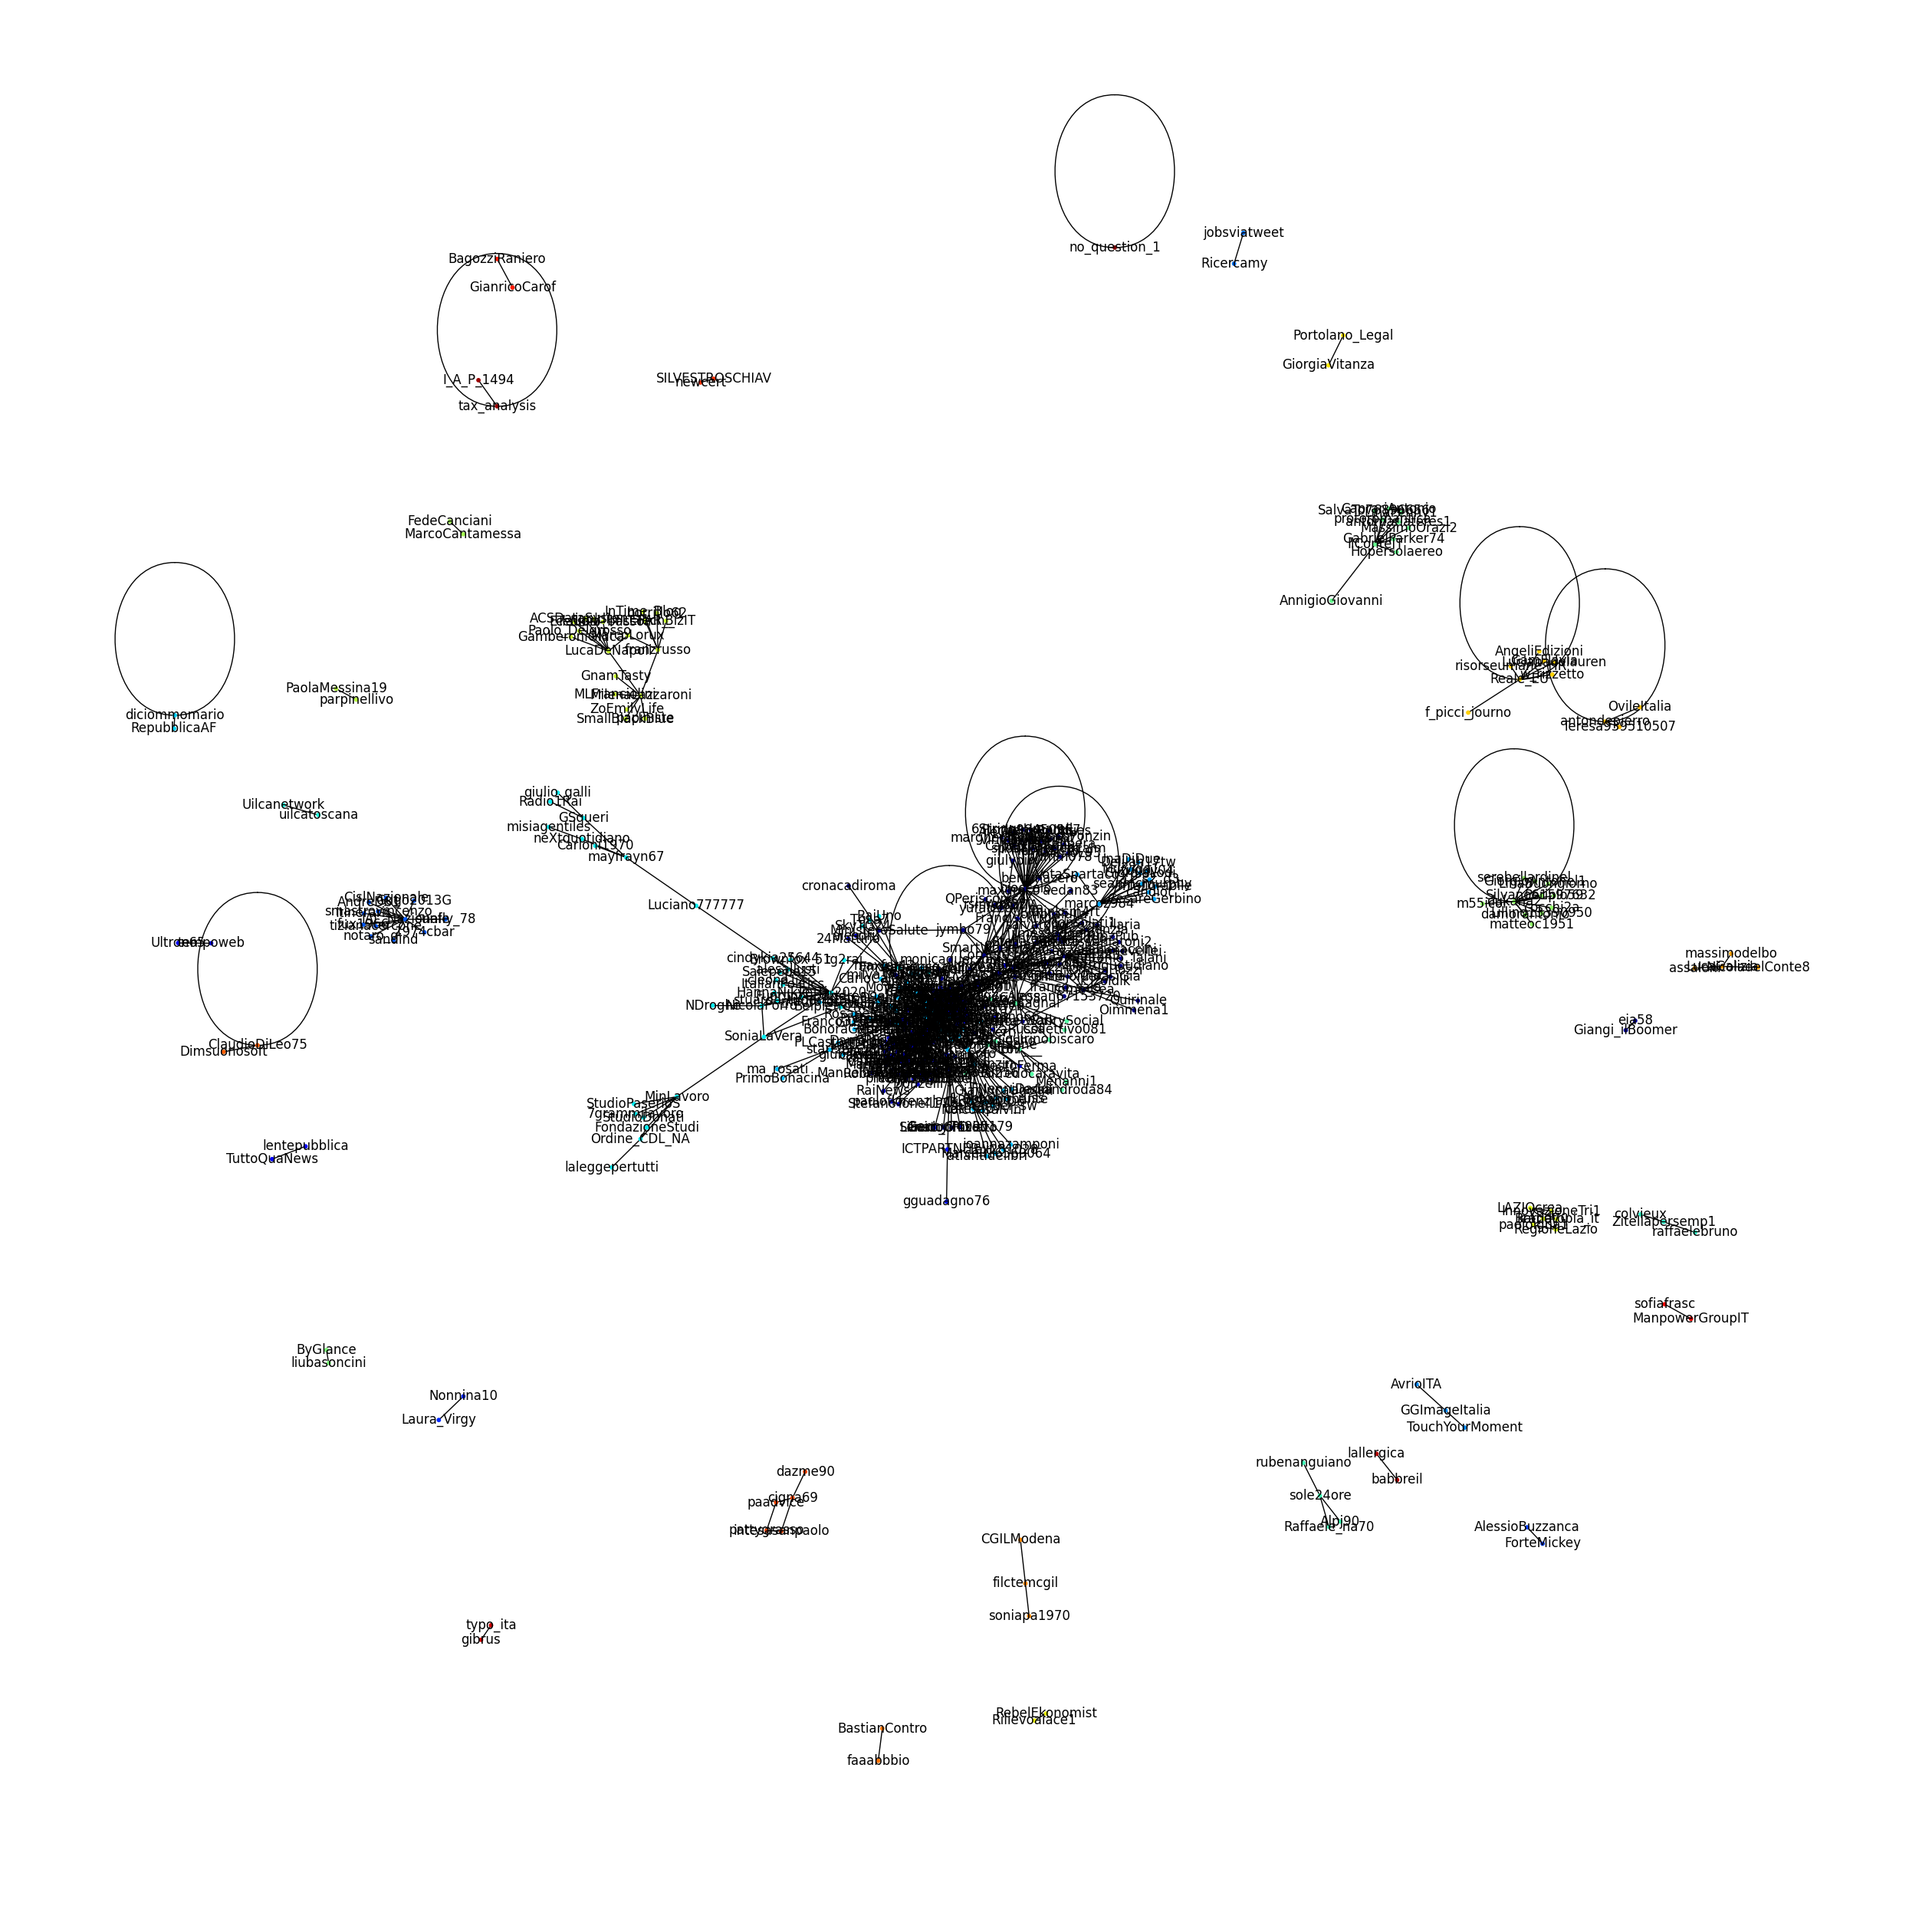

In [25]:
from community import community_louvain
import matplotlib.pyplot as plt

best_partitioon = community_louvain.best_partition(Graph)
modularity = community_louvain.modularity(best_partitioon, Graph)

nodes = [best_partitioon.get(node) for node in Graph.nodes()]

plt.figure(figsize=(25, 25))
nx.draw_spring(Graph, cmap=plt.get_cmap('jet'), node_color=nodes,
               node_size=10, with_labels=True)


## Visualization